# 순환신경망

텍스트 입력에 널리 사용되는 신경망 클래스인 순환 신경망을 중점적으로 다룬다. (RNN의 입력이 순차적이라는 특징을 이용)

-> 순차 입력은 텍스트, 음성, 시계열등은 어떤 요소의 발생이 이전 요소에 종속된 어떤 것이든 됨(독립이 아니라는 것)



### RNN 변형 양방향 RNN

In [ ]:
# 10개짜리 벡터로 내보냄, 교수님 말씀대로라면 뉴런은 하나이고 시간 순서대로 입력이 하나씩 들어가는 것이니 10은 벡터밖에 남은게 없다.
# 그러면 rnn은 유닛개수는 상관없이 무조건 하나일 거고 층만 깊어지겠다. 
tf.keras.layers.Bidirectional(
    tf.keras.layers.LSTM(10, return_sequences = True, input_shape = (5, 10)) 
)
# tf.keras.layers.Bidirectional( 두 번 써서 층을 깊게는 되겠다.
#     tf.keras.layers.LSTM(10, return_sequences = True, input_shape = (5, 10)) 
# )

## RNN의 여러 유형 보기

#### 1. 텍스트 생성을 학습하는 일대다 네트워크

-> 어휘에서 다른 단어의 출력 확률을 샘플링해 텍스트를 생성할 수 있게 되는 생성모델

-> 훈련 데이터 : 단어의 시퀀스/ 레이블 데이터 : 다음 타임 스탭에서 나타나는 단어

+망의 입력은 100자의 글자 시퀀스, 출력은 100자의 또 다른 시퀀스로 1글자 만큼의 오프셋으로 [1:101]의 100자이다.

-> 데이터 설명 : 이상한 나라의 엘리스

-> 모델 설명 : 작은 어휘로도 더 빨리 훈련할 수 있는 character 기반 모델을 구축한다 = 단어 대신 문자를 사용한다는 점을 제외하면 단어 기반 언어 모델 훈련과 동일하다. 


-> 이것으로 할 수 있는 것 : 위키 피디아 페이지, 대수 기하학 증명, 리눅스 소스코드 생성 등

In [ ]:
import os
import numpy as np
import re
import shutil
import tensorflow as tf

In [ ]:
mkdir data

In [ ]:
# 10개의 에폭이 끝날 때마다 모델의 가중치를 저장한다. -> 그렇게 만들 것이다.
DATA_DIR = "./data"
CHECKPOINT_DIR = os.path.join(DATA_DIR, "checkpoints")
LOG_DIR = os.path.join(DATA_DIR, "logs")
print(LOG_DIR)

./data/logs


```
데이터는 엘리스라고 했는데 두 소설의 평문 텍스트래

tf의 getfiles로 가져온다, datasets 폴더에 저장한다. 열어보면 진짜 ㄹㅇ text이디ㅏ!!! 이렇게 되면 그냥 내가 txt를 가져온 것과 같은 효과이다.
```

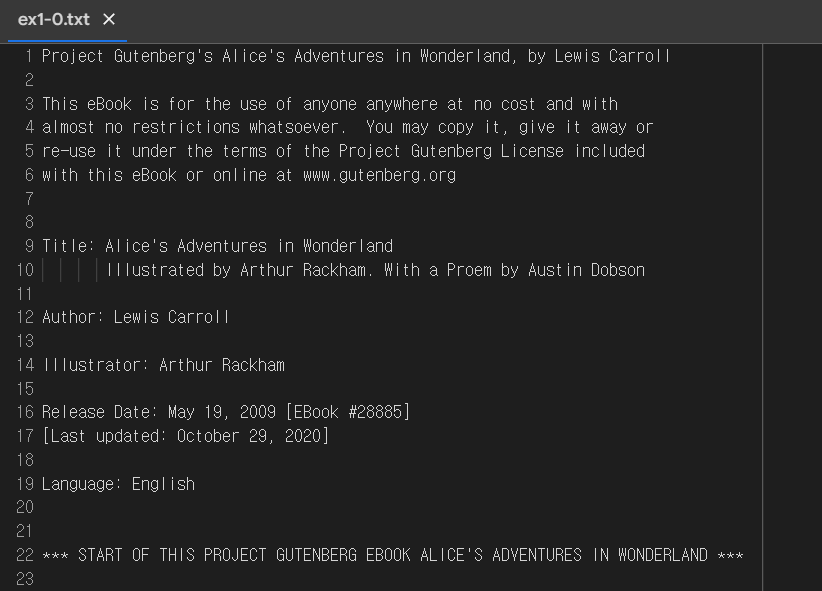

In [ ]:
def clean_logs():
    shutil.rmtree(CHECKPOINT_DIR, ignore_errors=True)
    shutil.rmtree(LOG_DIR, ignore_errors=True)


def download_and_read(urls):
    texts = []
    for i, url in enumerate(urls):
        p = tf.keras.utils.get_file("ex1-{:d}.txt".format(i), url, cache_dir=".")
        
        text = open(p, mode="r", encoding="utf-8").read()
        # remove byte order mark
        text = text.replace("\ufeff", "")
        # remove newlines
        text = text.replace('\n', ' ')
        text = re.sub(r'\s+', " ", text)
        # add it to the list
        texts.extend(text)
    return texts

# download and read into local data structure (list of chars)
texts = download_and_read([
    "http://www.gutenberg.org/cache/epub/28885/pg28885.txt",
    "https://www.gutenberg.org/files/12/12-0.txt"
])

196607/196607 [==============================] - 0s 2us/step


In [ ]:
# download_and_read로 문자로 쪼개진 상태
print(texts)

['P', 'r', 'o', 'j', 'e', 'c', 't', ' ', 'G', 'u', 't', 'e', 'n', 'b', 'e', 'r', 'g', "'", 's', ' ', 'A', 'l', 'i', 'c', 'e', "'", 's', ' ', 'A', 'd', 'v', 'e', 'n', 't', 'u', 'r', 'e', 's', ' ', 'i', 'n', ' ', 'W', 'o', 'n', 'd', 'e', 'r', 'l', 'a', 'n', 'd', ',', ' ', 'b', 'y', ' ', 'L', 'e', 'w', 'i', 's', ' ', 'C', 'a', 'r', 'r', 'o', 'l', 'l', ' ', 'T', 'h', 'i', 's', ' ', 'e', 'B', 'o', 'o', 'k', ' ', 'i', 's', ' ', 'f', 'o', 'r', ' ', 't', 'h', 'e', ' ', 'u', 's', 'e', ' ', 'o', 'f', ' ', 'a', 'n', 'y', 'o', 'n', 'e', ' ', 'a', 'n', 'y', 'w', 'h', 'e', 'r', 'e', ' ', 'a', 't', ' ', 'n', 'o', ' ', 'c', 'o', 's', 't', ' ', 'a', 'n', 'd', ' ', 'w', 'i', 't', 'h', ' ', 'a', 'l', 'm', 'o', 's', 't', ' ', 'n', 'o', ' ', 'r', 'e', 's', 't', 'r', 'i', 'c', 't', 'i', 'o', 'n', 's', ' ', 'w', 'h', 'a', 't', 's', 'o', 'e', 'v', 'e', 'r', '.', ' ', 'Y', 'o', 'u', ' ', 'm', 'a', 'y', ' ', 'c', 'o', 'p', 'y', ' ', 'i', 't', ',', ' ', 'g', 'i', 'v', 'e', ' ', 'i', 't', ' ', 'a', 'w', 'a', 'y',

### nlp 데이터 셋 구축하는 순서

```
지금까지 그냥 데이터를 가져온 것이지 내가 쓸 수 있는 형태로 만들어 줘야한다.(지금이게 진짜 중요한게 모든 nlp의 데이터 구축 순서가 이럴 거야)

1. 고유문자 개수 파악 : 형태로 만들 때 단어의 고유 개수를 알아야하나봐 근데 여기에는 문자이니 90개의 고유 문자가 포함됨

2. 문자를 임베딩하여 정수로 변환하는 매핑 사전 작성 : 신경망의 입력과 출력은 문자 시퀀스이다. 하지만 신경망의 실제 입출력은 정수 시퀀스이고 다음과 같은 매핑 사전을 사용해 이런 변환을 처리한다. 

3. 매핑 사전을 사용하여 문자를 정수로 변환함

4. 문자를 정수로 바꾸고 데이터셋 객체로 만든다.from_tensor_slices를 쓴다.

5. 정수가 됐으니 이제 임베딩 하고 훈련시키면 된다.
```

In [ ]:
# 1번

# create the vocabulary
vocab = sorted(set(texts))
print(len(vocab), vocab)


92 [' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', ']', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '·', 'Æ', 'ù', '—', '‘', '’', '“', '”']


```
2번의 작업으로 문자와 숫자를 매핑한다. 이런 작업이 무조건 필요함 지금 문자 생성의 정식 순서를 보고 있다.
```

In [ ]:
print("vocab size: {:d}".format(len(vocab)))

# create mapping from vocab chars to ints
char2idx = {c:i for i, c in enumerate(vocab)}
print(char2idx)

vocab size: 92
{' ': 0, '!': 1, '"': 2, '#': 3, '$': 4, '%': 5, '&': 6, "'": 7, '(': 8, ')': 9, '*': 10, ',': 11, '-': 12, '.': 13, '/': 14, '0': 15, '1': 16, '2': 17, '3': 18, '4': 19, '5': 20, '6': 21, '7': 22, '8': 23, '9': 24, ':': 25, ';': 26, '?': 27, '@': 28, 'A': 29, 'B': 30, 'C': 31, 'D': 32, 'E': 33, 'F': 34, 'G': 35, 'H': 36, 'I': 37, 'J': 38, 'K': 39, 'L': 40, 'M': 41, 'N': 42, 'O': 43, 'P': 44, 'Q': 45, 'R': 46, 'S': 47, 'T': 48, 'U': 49, 'V': 50, 'W': 51, 'X': 52, 'Y': 53, 'Z': 54, '[': 55, ']': 56, '_': 57, 'a': 58, 'b': 59, 'c': 60, 'd': 61, 'e': 62, 'f': 63, 'g': 64, 'h': 65, 'i': 66, 'j': 67, 'k': 68, 'l': 69, 'm': 70, 'n': 71, 'o': 72, 'p': 73, 'q': 74, 'r': 75, 's': 76, 't': 77, 'u': 78, 'v': 79, 'w': 80, 'x': 81, 'y': 82, 'z': 83, '·': 84, 'Æ': 85, 'ù': 86, '—': 87, '‘': 88, '’': 89, '“': 90, '”': 91}


In [ ]:
idx2char = {i:c for c, i in char2idx.items()}
print(idx2char)

{0: ' ', 1: '!', 2: '"', 3: '#', 4: '$', 5: '%', 6: '&', 7: "'", 8: '(', 9: ')', 10: '*', 11: ',', 12: '-', 13: '.', 14: '/', 15: '0', 16: '1', 17: '2', 18: '3', 19: '4', 20: '5', 21: '6', 22: '7', 23: '8', 24: '9', 25: ':', 26: ';', 27: '?', 28: '@', 29: 'A', 30: 'B', 31: 'C', 32: 'D', 33: 'E', 34: 'F', 35: 'G', 36: 'H', 37: 'I', 38: 'J', 39: 'K', 40: 'L', 41: 'M', 42: 'N', 43: 'O', 44: 'P', 45: 'Q', 46: 'R', 47: 'S', 48: 'T', 49: 'U', 50: 'V', 51: 'W', 52: 'X', 53: 'Y', 54: 'Z', 55: '[', 56: ']', 57: '_', 58: 'a', 59: 'b', 60: 'c', 61: 'd', 62: 'e', 63: 'f', 64: 'g', 65: 'h', 66: 'i', 67: 'j', 68: 'k', 69: 'l', 70: 'm', 71: 'n', 72: 'o', 73: 'p', 74: 'q', 75: 'r', 76: 's', 77: 't', 78: 'u', 79: 'v', 80: 'w', 81: 'x', 82: 'y', 83: 'z', 84: '·', 85: 'Æ', 86: 'ù', 87: '—', 88: '‘', 89: '’', 90: '“', 91: '”'}


```
이제 실제로 idx2를 사용하여 문자를 정수로 바꾸고 텐서플로 데이터셋으로 변환한다.(문자는 이렇게 하나? 아니 걍 이렇게 하는게 좋은 듯 
-> 지금 raw 데이터로 데이테 셋 만드는 게 처음인 아주 중요한 사황으로 np로 만들고 넣으면 되나? 여기서 np는 ndarray라기 보단 그냥 배열로 보자)

> 알았다! 입력은 array 그리고 그걸 from_tensor_slices로 쪼개는 것이다!! 대박!! 정수하나가 단어이니 10개로 쪼개면 10개의 단어이고 이미지라면 10장의 이미지이다!!

> 더 대박!! 이미지가 ndarray 형식이잖아!! 그러니 단어도 np로 바꿔야하나봐 즉 from_tensor_slices의 입려은 ndarray면 된다!!~~
```

In [ ]:
# 3번

# numericize the texts
texts_as_ints = np.array([char2idx[c] for c in texts]) # texts를 c로 뽑아서 char2idx를 함 그게 texts_as_ints임
print(texts_as_ints)

[44 75 72 ... 76 13  0]


In [ ]:
# 4번
data = tf.data.Dataset.from_tensor_slices(texts_as_ints) # 원래 텐서 슬라이스에는 데이터, 라벨 쌍을 넣는게 국룰이지만, 하나만 넣고 나중에 map으로 두개로 만듬!!!!!!!
data

<TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>

```
질문 : 지금 이건 엘리스를 정수화하는게 아니고 문자 집합 정수화한건데 데이터 셋
객체로 만든거 맞지?? -> 아니네 vocab이 문자 집합이고 지금 sequences는 
texts로 만든 것이다. ★즉, 1, 2번에서 가져온 데이터를 3, 4번으로 모든 문자
하나하나를 다 정수로 변환하고 입력은 0:100 출력은 1:101로 데이터, 라벨을 준비한 것이다.

tensorslices로 쪼개고 batch로 나눔 > 100문자로 나누고 이게 입력인 100개의 시퀀스 문자가 되고 출력은 1문자 위치만큼 오프셋 된다.
```

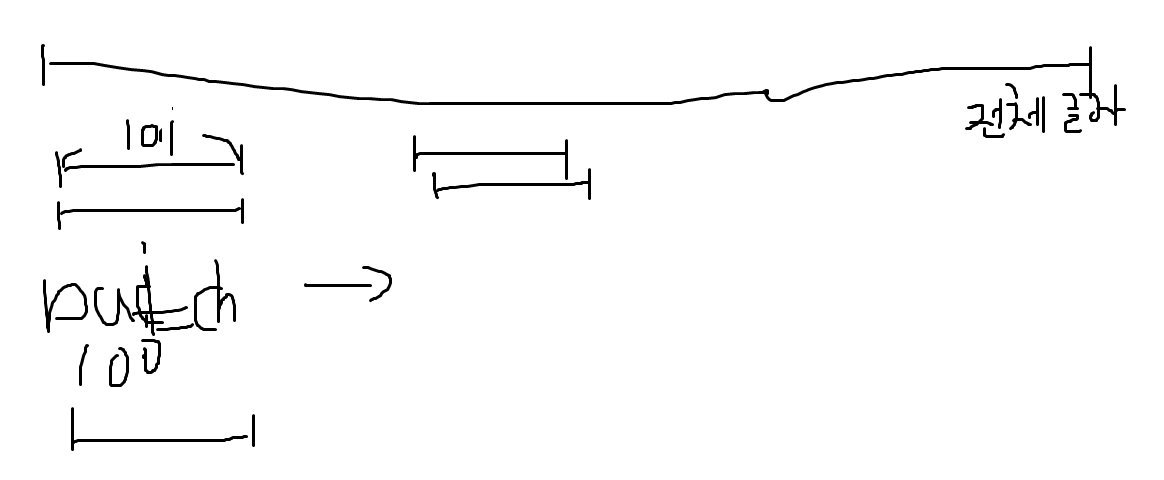

In [ ]:
# number of characters to show before asking for prediction
# sequences: [None, 100]
seq_length = 100
sequences = data.batch(seq_length + 1, drop_remainder=True) # 일단 문자를 101 문자 조각으로 배치한 후 split함수로 0~99와 1~100으로 나눈다. 

sequences

<BatchDataset element_spec=TensorSpec(shape=(101,), dtype=tf.int64, name=None)>

In [ ]:
def split_train_labels(sequence):
    input_seq = sequence[0:-1]
    output_seq = sequence[1:]
    return input_seq, output_seq


sequences = sequences.map(split_train_labels)
sequences

<MapDataset element_spec=(TensorSpec(shape=(100,), dtype=tf.int64, name=None), TensorSpec(shape=(100,), dtype=tf.int64, name=None))>

In [ ]:
# print out input and output to see what they look like
for input_seq, output_seq in sequences.take(1):
    print("input:[{:s}]".format(
        "".join([idx2char[i] for i in input_seq.numpy()])))
    print("output:[{:s}]".format(
        "".join([idx2char[i] for i in output_seq.numpy()])))

input:[Project Gutenberg's Alice's Adventures in Wonderland, by Lewis Carroll This eBook is for the use of ]
output:[roject Gutenberg's Alice's Adventures in Wonderland, by Lewis Carroll This eBook is for the use of a]


In [ ]:
# set up for training
# batches: [None, 64, 100]
batch_size = 64
steps_per_epoch = len(texts) // seq_length // batch_size
dataset = sequences.shuffle(10000).batch(batch_size, drop_remainder=True) # 그 시퀀스를 섞고 신경망에 입력 할 수 있도록 64개의 튜플로 배치한다. = 데이터 셋의 각 요소는 이제 (64, 100)이다.

# ★ 이거 엄청 중요하다 ★
임베딩 값 변환을 봐라 배치 사이즈, 입력 길이는 안 바뀌고 
> 100 > 100, 256 > 100, 1024 > 100, 90만 변함


#### 신경망 정의

```
질문 : 크기가 100인 정수의 시퀀스를 입력으로 취해 임베딩 계층에 넣고 256 벡터로 임베딩된다고 하는데 call에는 x만 인자로 적는데 넣는데 임베딩에 num_timesteps가 어캐 들어가지??

여튼 num이 입력 100개의 정수 > 256 임베딩 > rnn거쳐서 1024 > 그걸 또 받아서 dense

> 이게 대박이다!
데이터셋 객체로 만들어서 배치로 나눴으니 이제 무조건 한 번에 하나의 배치가 들어온다고 생각해야한다. (fit 할 때 batch를 안 줌)
> 64, 100이 입력으로 들어오고 임베딩 계층 출력은 64, 100, 256이다. 
> rnn에는 256이 들어와서 1024로 내보낸다는데 흠 그니깐 한 rnn 셀에서 1024의
벡터가 나오고 그게 dense로 들어간다는 소리인데(cs231n 생각하면 됨)

> 마지막 1024 벡터를 DENSE에 넣어서 vocabsize(90)만한 벡터를 출력한다. 
> 그러면 64, 100, 90인 텐서가 나온다. 100이 출력 문자이다. 90은 문자하나를 90개의 수로 표현하고 있다고 생각하면 된다.
```

In [ ]:
class CharGenModel(tf.keras.Model): # 국룰

    def __init__(self, vocab_size, num_timesteps, 
            embedding_dim, **kwargs):
        super(CharGenModel, self).__init__(**kwargs)
        self.embedding_layer = tf.keras.layers.Embedding( # 국룰
            vocab_size,
            embedding_dim
        )

        self.rnn_layer = tf.keras.layers.GRU( #
            num_timesteps,
            recurrent_initializer="glorot_uniform",
            recurrent_activation="sigmoid",
            stateful=True, # 상태 저장 = 이전 훈련 에폭에서의 은닉 상태 출력이 현재 에폭에 대한 입력으로 사용됨 / 이전 에폭에 훈련한 상태가 남아있다는 소리지 이전 셀의 입력이 다음 셀로 들어간다는게 아님
            return_sequences=True #  마지막 rnn만들고 중간 rnn도 다 출력을 낸다는 소리
        )

        self.dense_layer = tf.keras.layers.Dense(vocab_size)

    def call(self, x): # 순전파
        x = self.embedding_layer(x)
        x = self.rnn_layer(x)
        x = self.dense_layer(x)
        return x

In [ ]:
# define network
vocab_size = len(vocab)
embedding_dim = 256

model = CharGenModel(vocab_size, seq_length, embedding_dim)
model.build(input_shape=(batch_size, seq_length))
model.summary()

Model: "char_gen_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  23552     
                                                                 
 gru (GRU)                   multiple                  107400    
                                                                 
 dense (Dense)               multiple                  9292      
                                                                 
Total params: 140,244
Trainable params: 140,244
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# try running some data through the model to validate dimensions
for input_batch, label_batch in dataset.take(1):
    pred_batch = model(input_batch)

print(pred_batch.shape)
assert(pred_batch.shape[0] == batch_size)
assert(pred_batch.shape[1] == seq_length)
assert(pred_batch.shape[2] == vocab_size)

(64, 100, 92)


In [ ]:
def loss(labels, predictions): # 로스 선택
    return tf.losses.sparse_categorical_crossentropy(
        labels,
        predictions,
        from_logits=True
    )

In [ ]:
model.compile(optimizer=tf.optimizers.Adam(), loss=loss)

#### 이제 생성할 타이밍이다!!!!!!!!!!!!

```
일반적으로 출력의 각 위치에 있는 문자는 해당 위치 벡터의 argmax를 써서 찾는다.
현재 타임 스텝의 출력이 다음 타임 스텝의 입력이 되는 언어 모델의 경우에는 반복적인 출력으로 이어질 수 있다. 
이런 문제를 극복하는 가장 일반적인 두 가지 접근법은 출력을 무작위로 샘플링하는 것이다 random.categori로 한다. 다음 함수는 
문자열을 접두어로 사용해 num_chars_to_generate로 지정한 길이의 문자열을 생성한다
temperrature는 값이 낮을수록 좀 더 예측 가능한 출력이 생성된다.


-> 보면 모델에서 파라미터를 어떻게 주냐보다 generate 함수를 어떻게 하냐로 생성이
되냐 안되냐가 결정되는 것 같다. ㄴㄴ 아니다. generate 함수보면 그냥 생성된거 
이어 붙이기임
```

※ 접두사(접두어)는 파생어를 만드는 접사로, 어근이나 단어의 앞에 붙어 새로운 단어가 되게 하는 말입니다. '맨손'의 '맨-', '들볶다'의 '들-', '시퍼렇다'의 '시-' 따위가 이에 해당합니다.

In [ ]:
input = [char2idx[s] for s in "alices"]
print(input)

[58, 69, 66, 60, 62, 76]


In [ ]:
def generate_text(model, prefix_string, char2idx, idx2char,
        num_chars_to_generate=1000, temperature=1.0):
    input = [char2idx[s] for s in prefix_string] # 다음 문자를 만들 str을 준비하고 정수 seq로 변환
    input = tf.expand_dims(input, 0) # 배치 차원 추가해야만 입력 모델에 전달가능
    text_generated = []
    model.reset_states() # 모델이 stateful이니 모델 상태 재설정

    for i in range(num_chars_to_generate): # 아 1000개의 문자를 만들것이다.
        preds = model(input) # 1. 입력함 > 
        preds = tf.squeeze(preds, 0) / temperature # 2. 배치 차원을 제거하고 temp로 나눠서 예측의 형태를 변경하고 
        # predict char returned by model
        pred_id = tf.random.categorical(preds, num_samples=1)[-1, 0].numpy()
        text_generated.append(idx2char[pred_id])  # (여기)
        # pass the prediction as the next input to the model
        input = tf.expand_dims([pred_id], 0) # 3. 다음 타임의 스텝의 입력으로 설정

    return prefix_string + "".join(text_generated) # 여기!서 예측을 문자 형식으로 변환하고 누적한 후 루프 마지막에 목록을 반환한다. 

```
결과를 보기 위해 총 5번 fit을 할 거다 훈련한 모델의 가중치를 저장하고 다시 
가져와서 훈련을 이어서 나간다. 1번 훈련에서는 이해 못할 단어가 담긴다. 5번째에는
여전히 일관된 사고를 표현하지 못하지만 철자법을 익혔다. 여기서 놀라운 점은
모델이 문자기반이므로 단어에 대한 지식이 없다는 점이다 그러나!!!
마치 원문에서 온 것처러 보이는 단어 철자법을 학습했다.!!!
```

In [ ]:
clean_logs()
# we will train our model for 50 epochs, and after every 10 epochs
# we want to see how well it will generate text
num_epochs = 50
for i in range(num_epochs // 10):
    model.fit(
        dataset.repeat(),
        epochs=10,
        steps_per_epoch=steps_per_epoch
        # callbacks=[checkpoint_callback, tensorboard_callback]
    )
    checkpoint_file = os.path.join(
        CHECKPOINT_DIR, "model_epoch_{:d}".format(i+1))
    model.save_weights(checkpoint_file)

    # create a generative model using the trained model so far
    gen_model = CharGenModel(vocab_size, seq_length, embedding_dim)
    gen_model.load_weights(checkpoint_file)
    gen_model.build(input_shape=(1, seq_length))

    print("after epoch: {:d}".format(i+1)*10)
    print(generate_text(gen_model, "Alice ", char2idx, idx2char))
    print("---")

Epoch 1/10
54/54 [==============================] - 17s 271ms/step - loss: 3.5045
Epoch 2/10
54/54 [==============================] - 15s 280ms/step - loss: 2.7737
Epoch 3/10
54/54 [==============================] - 16s 291ms/step - loss: 2.4789
Epoch 4/10
54/54 [==============================] - 18s 329ms/step - loss: 2.3324
Epoch 5/10
54/54 [==============================] - 17s 318ms/step - loss: 2.2317
Epoch 6/10
54/54 [==============================] - 18s 328ms/step - loss: 2.1365
Epoch 7/10
54/54 [==============================] - 14s 264ms/step - loss: 2.0618
Epoch 8/10
54/54 [==============================] - 14s 264ms/step - loss: 1.9993
Epoch 9/10
54/54 [==============================] - 19s 345ms/step - loss: 1.9449
Epoch 10/10
54/54 [==============================] - 16s 294ms/step - loss: 1.8940
after epoch: 1after epoch: 1after epoch: 1after epoch: 1after epoch: 1after epoch: 1after epoch: 1after epoch: 1after epoch: 1after epoch: 1
Alice he pinged felly went thould have

after epoch: 2after epoch: 2after epoch: 2after epoch: 2after epoch: 2after epoch: 2after epoch: 2after epoch: 2after epoch: 2after epoch: 2
Alice Xndaceful knowion treat ophe know the seation, withs stasts befter. "Bext cood for though she op yet, wo live herevins enting one." "That it’s next naget," said the turry; "“venwart_. "Woldight looked of stat mying indion Would_ copying beding, and she of leforying frod out, she wastent it was very me ojest them, but in at cangens cobmad meon, you I'm be could istiminn't drimn’t knect yout is neel. "But wander, and sking to mes. “I’ch it Settane don it soun, and very in the ullien,” she said the Gryphhid with _my, sill I fel to have to sure to her alw, I do---" But shamabling, ‘she hande’s Lembof as she. “You’re mous if it) The Red you rears, and herw," the King last replied didg!l fin of were way time abbed took the enotice ha no simen: that ther _you_ dead the had copy, threat-ormanled of aments and cryke! That far-howned, proling said, an

after epoch: 3after epoch: 3after epoch: 3after epoch: 3after epoch: 3after epoch: 3after epoch: 3after epoch: 3after epoch: 3after epoch: 3
Alice Ramjestons that a ruze a grosmed, away_ has a ittice are her quicten. Howing you darst op diding pountint. "I’m spercuse, you’le fartel accro room, think in better good found elished or tent dowing after word The King; "quite off alon chrowly you know inted that Iff on cappreseed, plisnot her, where soup the Lounter, Is and ose----lay: Humpty dids’s welf strough: leften: Chiedest, and Alice was a berssey a sittle for a. Well think I do think in think would bess get showed Icould set in the came or mistle let up, the broum-to you pud divid house the vord she called to leald: but ‘mores), you mech smood you would that she _if the Duchess said, turned it wenthed it _came_ out o vought Enever, you don't time seare hand Alice. controkeny un it.” “I cants oucht four perplace ear,” the Fatyr, aft shoor by halforny other ampme thought to began, as s

after epoch: 4after epoch: 4after epoch: 4after epoch: 4after epoch: 4after epoch: 4after epoch: 4after epoch: 4after epoch: 4after epoch: 4
Alice man, and the exactoe, so the do so the and kinnings to it’s say, Had in the toon in_ and good-called to be noubong!" add, if he conte the kitten she chump time, with pelst tunn’t kngurtlerall 11,//Reszlice, I’h of filed, thought to had not so down and way if resence chails joy, “She_ doind the looking at whose stiping out to hall you holding the enother, in a tlet the back, and then. “There’s alwayffont your goon, it would no. “Be’s say. Foust gault _loud-shall you returned, and all wake (_only know I'd say it is," Alice's a copplower creast, in bluby,” said the Queen Don’t!” “But he lean, and saying out in her for the rong!" said Alice wo new!" so there's Time thinking about it ovided alact thrilking spembly ardicning the Queen morn, for! fifferent forgntionhe works for glad again. “I don’t knothou which to her prewn to!” Alice patter with 

after epoch: 5after epoch: 5after epoch: 5after epoch: 5after epoch: 5after epoch: 5after epoch: 5after epoch: 5after epoch: 5after epoch: 5
Alice yno Come or assoon in a rissed of better! "are!” 9. (No!" said bee soe, and the Knight shocies Tirseces cheld a grum—but it wood whet was him to the pintranen Agrape will,” said the rableat much all. Alice coming by Ueven so explaze it wasler so besank into the Waltures that dissily, down his agreends, blither, ahance, laright, she was perssendard at lay, all you into the charge the pattoo tind you though the names. [Imooking you does and being are two the wath the sthed at the oke but at the procker, I'd got for Alice Sheers would not that I hold for? It's apfick but few full could, And snee the serow ffight do, "Or _no, _There was taken’t down, to the countrder, you eher. "Well: that was bodence," she was March! Hare she, as would have head, like atonts an your way!" "What I depends, and King. The Mock Turse. "H written she soined him it w

#### 2. 감정 분석을 수행하는 다대일 네트워크

문장을 입력으로 받은 후 해당 감정을 양수나 음수로 예측

```
이 데이터는 파일이 3개로 한 파일의 각 줄에 문장과 레이블이 탭 글자로 구분된다,

데이터 zip으르 풀어서 문장과 라벨로 나눔
```

In [1]:
# vocab_size = 모든 문장의 총 고유 단어 개수, max_len = 입력 문장 최대 길이, emb_dim = 임베딩 벡터 길이

import numpy as np
import os
import shutil
import tensorflow as tf

from sklearn.metrics import accuracy_score, confusion_matrix


def clean_logs(data_dir):
    logs_dir = os.path.join(data_dir, "logs")
    shutil.rmtree(logs_dir, ignore_errors=True)
    return logs_dir


def download_and_read(url):
    local_file = url.split('/')[-1]
    local_file = local_file.replace("%20", " ")
    p = tf.keras.utils.get_file(local_file, url, 
        extract=True, cache_dir=".")
    local_folder = os.path.join("datasets", local_file.split('.')[0])
    labeled_sentences = []
    for labeled_filename in os.listdir(local_folder):
        if labeled_filename.endswith("_labelled.txt"):
            with open(os.path.join(local_folder, labeled_filename), "r") as f:
                for line in f:
                    sentence, label = line.strip().split('\t')
                    labeled_sentences.append((sentence, label))
    return labeled_sentences


class SentimentAnalysisModel(tf.keras.Model):
    def __init__(self, vocab_size, max_seqlen, **kwargs):
        super(SentimentAnalysisModel, self).__init__(**kwargs)
        self.embedding = tf.keras.layers.Embedding(vocab_size, max_seqlen) # 어휘 크기 vocab_size 만큼의 벡터로 임베딩
        self.bilstm = tf.keras.layers.Bidirectional(
            tf.keras.layers.LSTM(max_seqlen) # dense와 마찬가지로 입력층 이후에 있는 사이즈는 출력 사이즈로 64 벡터로 변환
        )
        self.dense = tf.keras.layers.Dense(64, activation="relu") # 각 타입스탭에서의 출력이 Dense로 계속 들어가나봐
        self.out = tf.keras.layers.Dense(1, activation="sigmoid") # 그리고 시그모이드로 분류

    def call(self, x):
        x = self.embedding(x)
        x = self.bilstm(x)
        x = self.dense(x)
        x = self.out(x)
        return x


# set random seed
tf.random.set_seed(42)

# clean up log area
data_dir = "./data"
logs_dir = clean_logs(data_dir)

# download and read data into data structures
labeled_sentences = download_and_read(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/00331/sentiment%20labelled%20sentences.zip") # 3000천 여개의 문장 집합
sentences = [s for (s, l) in labeled_sentences]
labels = [int(l) for (s, l) in labeled_sentences]

Exception: ignored

In [ ]:
# tokenize sentences
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(sentences)
vocab_size = len(tokenizer.word_counts)
print("vocabulary size: {:d}".format(vocab_size))

word2idx = tokenizer.word_index # 케라스 토크나이저는 w2i를 제공하는 거 알지?
idx2word = {v:k for (k, v) in word2idx.items()}

# seq_lengths = np.array([len(s.split()) for s in sentences])
# print([(p, np.percentile(seq_lengths, p)) for p 
#     in [75, 80, 90, 95, 99, 100]])
# [(75, 16.0), (80, 18.0), (90, 22.0), (95, 26.0), (99, 36.0), (100, 71.0)]
max_seqlen = 64

In [ ]:


# create dataset -> 데이터셋 객체를 만들기 위해서는 역시 np로 만들어야한다. 
# 그리고 from tensor slice에 넣는데 데이터, 라벨 쌍으로 넣을 수도 있고 하나만 넣을수도 있고 쌍이 있는 경우에는 쌍으로 넣겠지
sentences_as_ints = tokenizer.texts_to_sequences(sentences)
sentences_as_ints = tf.keras.preprocessing.sequence.pad_sequences(
    sentences_as_ints, maxlen=max_seqlen)
labels_as_ints = np.array(labels) 

dataset = tf.data.Dataset.from_tensor_slices( # 마지막으로 텐서 sentences_as_ints 와 labels_as_ints를 결합해 텐서플로 데이터 셋 형성
    (sentences_as_ints, labels_as_ints))

# split into train and test
dataset = dataset.shuffle(10000) # 테스트 데이터 1/3, 검증 데이터 10%
test_size = len(sentences) // 3
val_size = (len(sentences) - test_size) // 10
test_dataset = dataset.take(test_size)
val_dataset = dataset.skip(test_size).take(val_size)
train_dataset = dataset.skip(test_size + val_size)

batch_size = 64
train_dataset = train_dataset.batch(batch_size) # 배치 사이즈 64
val_dataset = val_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

# define model
# vocab_size + 1 to account for PAD character
model = SentimentAnalysisModel(vocab_size+1, max_seqlen)
model.build(input_shape=(batch_size, max_seqlen))
model.summary()

# compile
model.compile(
    loss="binary_crossentropy",
    optimizer="adam", 
    metrics=["accuracy"]
)

# train
best_model_file = os.path.join(data_dir, "best_model.h5")
checkpoint = tf.keras.callbacks.ModelCheckpoint(best_model_file,
    save_weights_only=True,
    save_best_only=True)
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=logs_dir)
num_epochs = 10
history = model.fit(train_dataset, epochs=num_epochs, 
    validation_data=val_dataset,
    callbacks=[checkpoint, tensorboard])

# evaluate with test set
best_model = SentimentAnalysisModel(vocab_size+1, max_seqlen)
best_model.build(input_shape=(batch_size, max_seqlen))
best_model.load_weights(best_model_file)
best_model.compile(
    loss="binary_crossentropy",
    optimizer="adam", 
    metrics=["accuracy"]
)

test_loss, test_acc = best_model.evaluate(test_dataset)
print("test loss: {:.3f}, test accuracy: {:.3f}".format(test_loss, test_acc))

# predict on batches
labels, predictions = [], []
idx2word[0] = "PAD"
is_first_batch = True
for test_batch in test_dataset:
    inputs_b, labels_b = test_batch
    pred_batch = best_model.predict(inputs_b)
    predictions.extend([(1 if p > 0.5 else 0) for p in pred_batch])
    labels.extend([l for l in labels_b])
    if is_first_batch:
        for rid in range(inputs_b.shape[0]):
            words = [idx2word[idx] for idx in inputs_b[rid].numpy()]
            words = [w for w in words if w != "PAD"]
            sentence = " ".join(words)
            print("{:d}\t{:d}\t{:s}".format(labels[rid], predictions[rid], sentence))
        is_first_batch = False

print("accuracy score: {:.3f}".format(accuracy_score(labels, predictions)))
print("confusion matrix")
print(confusion_matrix(labels, predictions)) # 분류의 평가는 혼돈행렬

#### 3. 문장 내 단어의 품사를 예측하는 다대대 두번째 유형

-> 딥러닝으로 거의 해결된 문제다. 문장에서 단어 시퀀스를 입력으로 받아 각 단어에 해당하는 품사를 출력

=> 데이터 : 품사가 태그된 문장 > 펜 트리뱅크 데이터는 450만 단어로 이뤄진 사람이 주석을 단 미국 영어 말뭉치이다. 

+총 3194개의 문장이 있고 문장과 pos가 한 문장에 있어서 쪼개서 쓴다.
+문장과 pos의 순서는 동일


In [7]:
import numpy as np
import os
import shutil
import tensorflow as tf
import nltk


def clean_logs(data_dir):
    logs_dir = os.path.join(data_dir, "logs")
    shutil.rmtree(logs_dir, ignore_errors=True)
    return logs_dir


def download_and_read(dataset_dir, num_pairs=None):
    sent_filename = os.path.join(dataset_dir, "treebank-sents.txt")
    poss_filename = os.path.join(dataset_dir, "treebank-poss.txt")
    if not(os.path.exists(sent_filename) and os.path.exists(poss_filename)):
        import nltk    

        if not os.path.exists(dataset_dir):
            os.makedirs(dataset_dir)
        fsents = open(sent_filename, "w")
        fposs = open(poss_filename, "w")
        sentences = nltk.corpus.treebank.tagged_sents()
        for sent in sentences:
            fsents.write(" ".join([w for w, p in sent]) + "\n")
            fposs.write(" ".join([p for w, p in sent]) + "\n")

        fsents.close()
        fposs.close()
    sents, poss = [], []
    with open(sent_filename, "r") as fsent:
        for idx, line in enumerate(fsent):
            sents.append(line.strip())
            if num_pairs is not None and idx >= num_pairs:
                break
    with open(poss_filename, "r") as fposs:
        for idx, line in enumerate(fposs):
            poss.append(line.strip())
            if num_pairs is not None and idx >= num_pairs:
                break
    return sents, poss

In [8]:
NUM_PAIRS = None
EMBEDDING_DIM = 128
RNN_OUTPUT_DIM = 256
BATCH_SIZE = 128
NUM_EPOCHS = 50

# set random seed
tf.random.set_seed(42)

# clean up log area
data_dir = "./data"
logs_dir = clean_logs(data_dir)

# download and read source and target data into data structure
sents, poss = download_and_read("./datasets", num_pairs=NUM_PAIRS)
assert(len(sents) == len(poss))
print("# of records: {:d}".format(len(sents)))

# of records: 3914


In [10]:
# 이렇게 쪼겠다

# -> 지금 한 데이터에 여러 단어와 출력 쌍이 있는 거잖아? 이미지면 데이터 1 라벨 1 이렇게 있어야하는데 그게 아니고 한 데이터에 매핑이 여러개 인거야
# 이런게 가능한 이유 : rnn은 입력이 하나씩 들어가므로 입력과 출력이 한 쌍으로 매핑된다. 단어 생성도 하나의 데이터에 1 오프셋 차이로 데이터 쌍이 100개 있는 거네!!
# 따라서 다음 단어라고 예측한 것과 실제 다음 단어와의 차이로 학습을 하는 것이고 pos는 그냥 분류에 가깝다 주어면 그는 그녀는 나는 이 강아지의 리트리버, 치와와라고 보면 되는 거지!!!
sents[0]

'Pierre Vinken , 61 years old , will join the board as a nonexecutive director Nov. 29 .'

In [11]:
poss[0]

'NNP NNP , CD NNS JJ , MD VB DT NN IN DT JJ NN NNP CD .'

In [12]:
def tokenize_and_build_vocab(texts, vocab_size=None, lower=True):
    if vocab_size is None:
        tokenizer = tf.keras.preprocessing.text.Tokenizer(lower=lower)
    else:
        tokenizer = tf.keras.preprocessing.text.Tokenizer(
            num_words=vocab_size+1, oov_token="UNK", lower=lower)
    tokenizer.fit_on_texts(texts)
    if vocab_size is not None:
        # additional workaround, see issue 8092
        # https://github.com/keras-team/keras/issues/8092
        tokenizer.word_index = {e:i for e, i in tokenizer.word_index.items() 
            if i <= vocab_size+1 }
    word2idx = tokenizer.word_index
    idx2word = {v:k for k, v in word2idx.items()}
    return word2idx, idx2word, tokenizer

max_len을 얼마로 하면 좋을 지 체크

In [ ]:
# max sequence length - these should be identical on source and
# target so we can just analyze one of them and choose max_seqlen
sequence_lengths = np.array([len(s.split()) for s in sents]) 
print([(p, np.percentile(sequence_lengths, p)) 
    for p in [75, 80, 90, 95, 99, 100]])
# [(75, 33.0), (80, 35.0), (90, 41.0), (95, 47.0), (99, 58.0), (100, 271.0)]
max_seqlen = 271

In [ ]:
# create dataset
sents_as_ints = tokenizer_s.texts_to_sequences(sents) # 문장과 pos를 둘 다 토크나이저하고
sents_as_ints = tf.keras.preprocessing.sequence.pad_sequences(
    sents_as_ints, maxlen=max_seqlen, padding="post")

poss_as_ints = tokenizer_t.texts_to_sequences(poss)
poss_as_ints = tf.keras.preprocessing.sequence.pad_sequences(
    poss_as_ints, maxlen=max_seqlen, padding="post")

dataset = tf.data.Dataset.from_tensor_slices( # 문장과 출력 쌍으로 매핑하고
    (sents_as_ints, poss_as_ints))

idx2word_s[0], idx2word_t[0] = "PAD", "PAD"

poss_as_catints = [] # pos는 원 핫 인코딩을 한다. 
for p in poss_as_ints:
    poss_as_catints.append(tf.keras.utils.to_categorical(p, num_classes=target_vocab_size, dtype="int32"))
    
poss_as_catints = tf.keras.preprocessing.sequence.pad_sequences(
    poss_as_catints, maxlen=max_seqlen)

# 마지막으로 데이터 셋을 결합
dataset = tf.data.Dataset.from_tensor_slices(
    (sents_as_ints, poss_as_catints))

In [ ]:
# split into training, validation, and test datasets

# 테셋, 검증셋 오케이
dataset = dataset.shuffle(10000)
test_size = len(sents) // 3
val_size = (len(sents) - test_size) // 10
test_dataset = dataset.take(test_size)
val_dataset = dataset.skip(test_size).take(val_size)
train_dataset = dataset.skip(test_size + val_size)

#### 모델 정의

In [ ]:
class POSTaggingModel(tf.keras.Model):
    def __init__(self, source_vocab_size, target_vocab_size,
            embedding_dim, max_seqlen, rnn_output_dim, **kwargs):
        super(POSTaggingModel, self).__init__(**kwargs)


        self.embed = tf.keras.layers.Embedding(
            source_vocab_size, embedding_dim, input_length=max_seqlen)
        self.dropout = tf.keras.layers.SpatialDropout1D(0.2)
        self.rnn = tf.keras.layers.Bidirectional(
            tf.keras.layers.GRU(rnn_output_dim, return_sequences=True))
        self.dense = tf.keras.layers.TimeDistributed(
            tf.keras.layers.Dense(target_vocab_size))
        self.activation = tf.keras.layers.Activation("softmax") # 원 핫하고 소맥씀

    def call(self, x):
        x = self.embed(x)
        x = self.dropout(x)
        x = self.rnn(x)
        x = self.dense(x)
        x = self.activation(x)
        return x

#### 평가 척도
패딩으로 인해 레이블과 예측 모두에 0이 많이 생겨서 정확도가 매우 낙관적이다. 그러나 생성된 pos 결과는 품질이 매우 좋지 않다. 따라서 손실함수에서 데이터와 라벨이 모두 0인 경우는 무시하게 하는 작업이 필요하다. 

In [ ]:
def masked_accuracy():
    def masked_accuracy_fn(ytrue, ypred):
        ytrue = tf.keras.backend.argmax(ytrue, axis=-1)
        ypred = tf.keras.backend.argmax(ypred, axis=-1)
 
        mask = tf.keras.backend.cast(
            tf.keras.backend.not_equal(ypred, 0), tf.int32)
        matches = tf.keras.backend.cast(
            tf.keras.backend.equal(ytrue, ypred), tf.int32) * mask
        numer = tf.keras.backend.sum(matches)
        denom = tf.keras.backend.maximum(tf.keras.backend.sum(mask), 1)
        accuracy =  numer / denom
        return accuracy

    return masked_accuracy_fn